# Extracting drydown periods from soil moisture timeseries

The following script loads a timeseries of root-zone soil moisture obtained from the Soil Moisture Active-Passive (SMAP) satellite mission, extracts drydown periods, and characterizes each drydown period by using the parameter of a simple exponential decay model to is fitted to each drydown period.


A drydown represents a soil moisture timeseries of consecutive days without rainfall events. Formally, any particular day is part of a drydown period if $SWC_{t} < SWC_{t-1}$ In this particular script we will consider small positive changes in soil moisture between consecutive days as part of the drydown. This small positive changes could be due to small rainfall events, fog, dew, and even noise in the signal.

The tabulated file also contains information about date, day of the year, and the evaporative demand drought index (EDDI), which is a metric of the anomalies in atmospheric evaporative demand. It is important to highlight that EDDI is not a good predictor of the atmospheric demand, but of the demand relative to historical values.

Let's first import some python modules, all of which are available with the Anaconda package:

In [2]:
# Import Python modules
import pandas as pd
import numpy as np
import glob
from pprint import pprint
from scipy.optimize import curve_fit

%matplotlib inline
import matplotlib.pyplot as plt

## Model description

Before we even dive into the script I want to show you what several examples of drydowns based on the exponential model that we will use later on in this script. Soil moisture can increase rapidly during and soon after rainfall events. In subsequent days soil moisture dries at a decreasing rate resembling an exponential decay, which depends on atmospheric demand, soil type and structure, and the presence of vegetation. The lines below represent possible decays under different scenarios.

$$ SWC = A e^{-\frac{t}{\tau}} + \theta_{res}$$

SWC = Soil water content in $m^{3}/m^{3}$

A = The initial soil water content $m^{3}/m^{3}$. Soil water at time t=0

t = Days since rainfall event

$\tau$ = Constant the modulates the rate at which the soil dries

$\theta_{res}$ = Residual soil water content $m^{3}/m^{3}$. This is a lower limit that needs to be determined from the data. Alternatively this value can be found by using pedo-transfer functions that relate the residual water content as a function of soil texture (e.g. percent sand content)


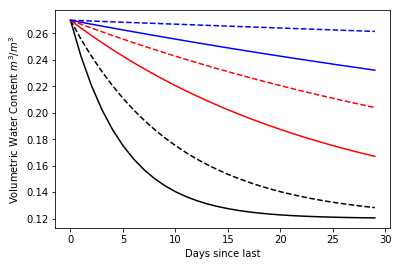

In [5]:
# Define model using an anonymous lamda function
model = lambda t,tau: 0.15 * np.exp(-t/tau) + 0.12;

# Rapid decay. Typical of summer days with actively growing vegetation
plt.plot(np.arange(30),model(np.arange(30),5),'-k')     
plt.plot(np.arange(30),model(np.arange(30),10),'--k')

# Intermediate drydowns typical of spring and fall, or perhaps fine-texture soils
plt.plot(np.arange(30),model(np.arange(30),25),'-r')
plt.plot(np.arange(30),model(np.arange(30),50),'--r')

# Drydowns typical during the winter showing low or almost no change
plt.plot(np.arange(30),model(np.arange(30),100),'-b')
plt.plot(np.arange(30),model(np.arange(30),500),'--b')
plt.xlabel('Days since last')
plt.ylabel('Volumetric Water Content $m^3/m^3$')
plt.show()

## Load dataset

Test dataset was compile for the following spatial and temporal parameters:

start_date = '1-jan-2016'

end_date = '18-may-2018'

lat = 38.730981

lon = -97.416299

missing values = NaN

In [6]:
# Navigate to fiel directory
glob.os.chdir("/Users/andrespatrignani/Dropbox/Teaching/Scientific programming/pynotes/datasets/")


In [7]:
data = pd.read_csv('smap_eddi_timeseries.csv')
data.head(5)

,date,doy,rootzone,surface,eddi
0,01-Jan-2016 00:00:00,1,0.360348,0.377937,2.104648
1,02-Jan-2016 00:00:00,2,0.360385,0.377916,2.104648
2,03-Jan-2016 00:00:00,3,0.360442,0.378046,1.701410
3,04-Jan-2016 00:00:00,4,0.360362,0.377900,1.701410
4,05-Jan-2016 00:00:00,5,0.359971,0.377537,1.701410


Just in case,  let's convert dates in to Pandas datetime format and check that the conversion was successful

In [8]:
data.date = pd.to_datetime(data.date)
data.head(5)

,date,doy,rootzone,surface,eddi
0,2016-01-01,1,0.360348,0.377937,2.104648
1,2016-01-02,2,0.360385,0.377916,2.104648
2,2016-01-03,3,0.360442,0.378046,1.701410
3,2016-01-04,4,0.360362,0.377900,1.701410
4,2016-01-05,5,0.359971,0.377537,1.701410


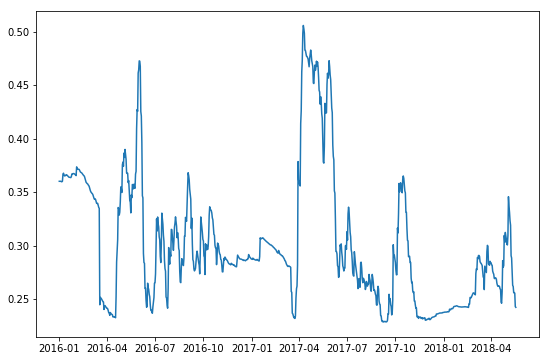

In [9]:
# Plot timeseries of soil moisture and EDDI
plt.figure(figsize=(9,6))
plt.plot(data.date,data.rootzone)
plt.show()

The SMAP signal shows some increases and decreases that might not be real. Particularly the dramatic reductions in soil moisture occurrying in the span of one or two days (see sharp reduction of soil moisture change near March-2016, this will also be evident in the plot below when we overlay the drydown periods)

In [10]:
# Find residual volumetric water content
# We can also approximate this value by taking the first or fifth percentiles for example
theta_res = data.rootzone.min()
print(theta_res)

0.228831380605698


In [11]:
# Iterate over soil moisture timeseries to retrieve drydowns

drydown_counter = 0
day_counter = 0

drydowns = [{'date':[],'rootzone':[],'doy':[],'days':[],'eddi':[],'length':[]}]

# We start the loop on the second day
for i in range(1,len(data)):
    delta = data.rootzone[i] - data.rootzone[i-1]
    
    if delta < 0.0025:
        drydowns[drydown_counter]['date'].append(data.date[i])
        drydowns[drydown_counter]['rootzone'].append(data.rootzone[i])
        drydowns[drydown_counter]['doy'].append(data.doy[i])
        drydowns[drydown_counter]['days'].append(day_counter)
        drydowns[drydown_counter]['eddi'].append(data.eddi[i])
        drydowns[drydown_counter]['length'] = day_counter+1
        day_counter += 1
        
    else:
        drydown_counter += 1
        day_counter = 0
        drydowns.append({'date':[],'rootzone':[],'doy':[],'days':[],'eddi':[],'length':[]})


In [12]:
drydowns_clean = []
for i in range(len(drydowns)):
    if (drydowns[i]['length'] != [] and drydowns[i]['length'] > 5):
        drydowns_clean.append(drydowns[i])
        
print('There are a total of',len(drydowns_clean),'drydowns')   


There are a total of 37 drydowns


In [13]:
# Print dictionary with all the data for the first drydown period.
# The pretty print module just makes the dictionary easy to read. Keys are sorted alphabetically
pprint(drydowns_clean[0])

{'date': [Timestamp('2016-01-02 00:00:00'),
          Timestamp('2016-01-03 00:00:00'),
          Timestamp('2016-01-04 00:00:00'),
          Timestamp('2016-01-05 00:00:00'),
          Timestamp('2016-01-06 00:00:00'),
          Timestamp('2016-01-07 00:00:00')],
 'days': [0, 1, 2, 3, 4, 5],
 'doy': [2, 3, 4, 5, 6, 7],
 'eddi': [2.10464835,
          1.70140982,
          1.70140982,
          1.70140982,
          1.46677959,
          1.46677959],
 'length': 6,
 'rootzone': [0.360384732484818,
              0.36044219136238104,
              0.36036217212677,
              0.35997149348259,
              0.35990142822265603,
              0.360380560159683]}


## Overlay soil moisture timeseries and extracted drydowns

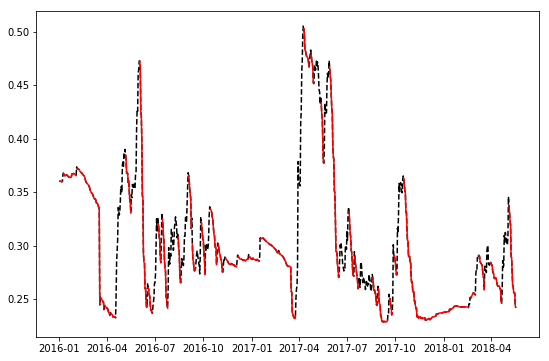

In [14]:
plt.figure(figsize=(9,6))
plt.plot(data.date,data.rootzone,'--k')

for i in range(len(drydowns_clean)):
    plt.plot(drydowns_clean[i]['date'],drydowns_clean[i]['rootzone'],'-r')
    
plt.show()

## Overlay soil moisture timeseries, extracted drydowns, and fitted model

It's important to highlight that:

- the "x" variable, in this case $t$ needs to be defined first in the lambda function

- the lambda function needs to be defined in each iteration to ensure that $A$ is updated with the initial soil moisture of the current drydown period in the iteration process.

- It is possible to also fit $A$, but since we do know the value of the parameter from the soil moisture signal it is better to force the model thourhg this value and only optimize tau.

- The $\theta_{res} is considered constant. In other words, for any day of the year it assumed that the soil moisture tends towards this point.

- Values of $\tau$ are inversely related to the drydown rate

In [17]:
for i in range(len(drydowns_clean)):
    xdata = drydowns_clean[i]['days']
    ydata = drydowns_clean[i]['rootzone']
    A = drydowns_clean[i]['rootzone'][0] - theta_res # Initial soil moisture minus theta_res
    model = lambda t,tau: A * np.exp(-t/tau) + theta_res; # Define lambda function in each iteration
    par_opt, par_cov = curve_fit(model, xdata, ydata)
    drydowns_clean[i]['tau'] = par_opt[0]


/Users/andrespatrignani/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


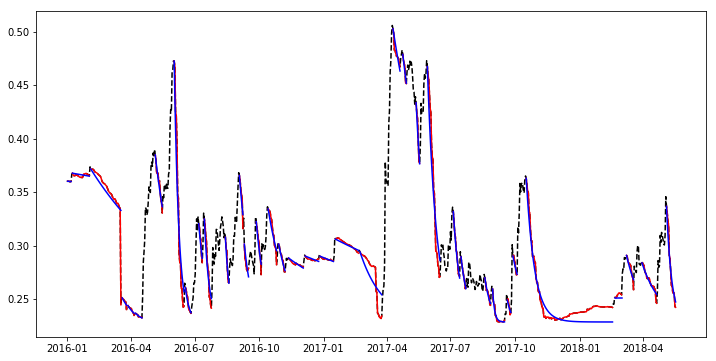

In [18]:
plt.figure(figsize=(12,6))
plt.plot(data.date,data.rootzone,'--k')

for i in range(len(drydowns_clean)):
    plt.plot(drydowns_clean[i]['date'],drydowns_clean[i]['rootzone'],'-r')
    
    A = drydowns_clean[i]['rootzone'][0] - theta_res
    model = lambda t,tau: A * np.exp(-t/tau) + theta_res;
    plt.plot(drydowns_clean[i]['date'],model(np.array(drydowns_clean[i]['days']), drydowns_clean[i]['tau']),'-b')
    
plt.show()


## Magnitude of Tau versus EDDI

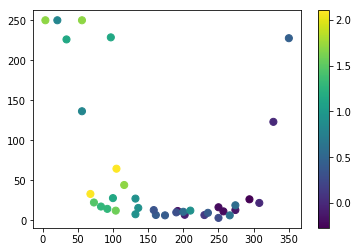

In [23]:
# Note that some EDDI maps were not available and so the EDDI value 
# for the selected Lat and Lon were replaced by NaN, reason why we need to use a function such as
# np.nanmedian that ignores NaN values.

doy_center = []
tau = []
median_eddi = []
for i in range(len(drydowns_clean)):
    doy_center.append(np.round(np.mean(drydowns_clean[i]['doy'])))
    tau.append(min(drydowns_clean[i]['tau'],250)) # Set an upper limit of 250 for Tau
    median_eddi.append(np.nanmedian(drydowns_clean[i]['eddi']))


plt.scatter(doy_center,tau,50,median_eddi)
plt.colorbar()
plt.show()

## Comments and Questions

- As expected Tau values are small during times of the year with high atmospheric demand and high during times of the year with low atmpsheric demands.

- Setting a maximum Tau value to 250 or 500 seems reasonable. The difference between curves with Tau=500 and Tau=2000 are imperceptible (Try this with the very first examples).

- This analysis could be repeated for each SMAP EASE grid cell within Kansas, or cells within agroclimatic regions. The latter would allow you to group lots of Tau values and compensate for the relatively short timeseries of the SMAP mission.

- Perhaps the mean value of Tau can be predicted as a function of the day of the year and then according to the EDDI value we could increase/decrease the value of Tau. If EDDI is analogous to standard deviation, then it should be straight forard to have a mean and standard deviation of Tau for each day of the year and select values according to the most recent EDDI.

- We might need to only consider drydown periods longer than 10 or even 15 days to better represent 30-day forecasts. This will susbtantially reduce the number of extracted drydowns, but it could make the analysis more robust.

- We could determine Tau paramters from drydown period using SMAP timeseries from Mar-2015 to Dec-2017 and then inspect and select some drydowns from Jan-2018 to now to test the predicting power. Note that while the shape of the drydown may not matchthe observed values, we could simply compare the very last value (the value after 30 days)

- Since EDDI is an indication of the anomalous demand rather than and indicator of the absolute magnitude of the atmospheric evaporative demand, I'm not sure how to best use it. Something like vapor pressure deficit, evapotranspiration, or even air temperature, could be a better proxy for Tau.

- Are different Tau values for the same day of the year correlated to EDDI values? I wonder if these anamalies in the atmospheric demand also propagate and affect the soil moisture dynamics. In other words, if we have a an exceptionally higher atmospheric demand do we also see a lower Tau value?
